<a href="https://colab.research.google.com/github/Ahmed-Elshoubashy/Topology-Mapping/blob/master/Topology_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload Dataset

In [1]:
from google.colab import files
files.upload();

Saving dataset.zip to dataset.zip


In [0]:
!unzip -q dataset.zip

In [0]:
import numpy as np

# Function to read the topologies

In [0]:
def read_data (size):
  topology = np.zeros((10 , size ,size))
  for i in range(10):
    path = 't_'+str(size)+'_'+str(i)+'.txt'
    with open('/content/Dataset/'+path) as f:
     for line in f: 
      from_node , to_node , weight = ([int(x) for x in line.split()])
      topology[i][from_node-1][to_node-1] += weight
      topology[i][to_node-1][from_node-1] += weight
  return topology

# Function to read the ground truth

In [0]:
def read_truth():
  path = '/content/Dataset/ground_truth.txt'
  ret_10, ret_50 = [], []
  with open(path) as doc:
    for i,line in enumerate(doc):
      line_list = list(map(int, line.split()))
      if i < 10:
        ret_10.append(line_list)
      else:
        ret_50.append(line_list)
  ret_10 = np.reshape(np.array(ret_10), (10, 10))
  ret_50 = np.reshape(np.array(ret_50), (10, 50))
  return ret_10, ret_50

# Reading the topologies

In [0]:
topology_10 = read_data(10).astype(int)
topology_50 = read_data(50).astype(int)
topology_100 = read_data(100).astype(int)

# Reading the ground truth

In [0]:
truth_10, truth_50 = read_truth()

# Function to print a graph of a topology

In [0]:
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(topology, col = None, title = None):
  G = nx.from_numpy_matrix(np.matrix(topology), create_using=nx.Graph)
  plt.figure(figsize = (12, 9))
  ax = plt.gca()
  ax.axis('off')
  layout = nx.circular_layout(G)
  labels = nx.get_edge_attributes(G, "weight")
  nodes = {x : x + 1 for x in range(topology.shape[0])}
  nx.draw_networkx(G, pos = layout, with_labels = False)
  nx.draw_networkx_edge_labels(G, pos = layout, edge_labels= labels);
  nx.draw_networkx_labels(G, layout, nodes, font_size= 12)
  nx.draw_networkx_nodes(G, pos = layout, node_color = col)
  plt.title(title)
  plt.show()
  print('==========================================================='.center(85))
  plt.close()

In [0]:
def compare_clusters(topology, col = None, title = None):
  G = nx.from_numpy_matrix(np.matrix(topology), create_using=nx.Graph)
  plt.figure(figsize = (12, 9))
  ax = plt.gca()
  ax.axis('off')
  layout = nx.circular_layout(G)
  labels = nx.get_edge_attributes(G, "weight")
  nodes = {x : x + 1 for x in range(topology.shape[0])}
  nx.draw_networkx(G, pos = layout, with_labels = False)
  nx.draw_networkx_edge_labels(G, pos = layout, edge_labels= labels);
  nx.draw_networkx_labels(G, layout, nodes, font_size= 12)
  nx.draw_networkx_nodes(G, pos = layout, node_color = col)
  plt.title(title)
  plt.show()
  print('==========================================================='.center(85))
  plt.close()

# Visualizing the topologies

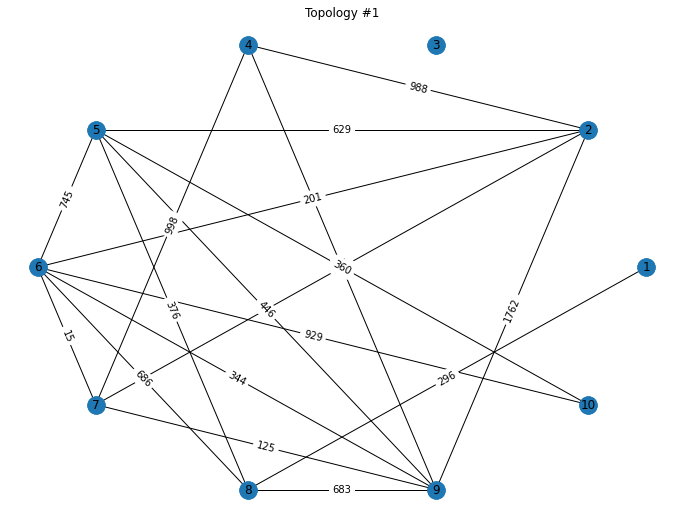

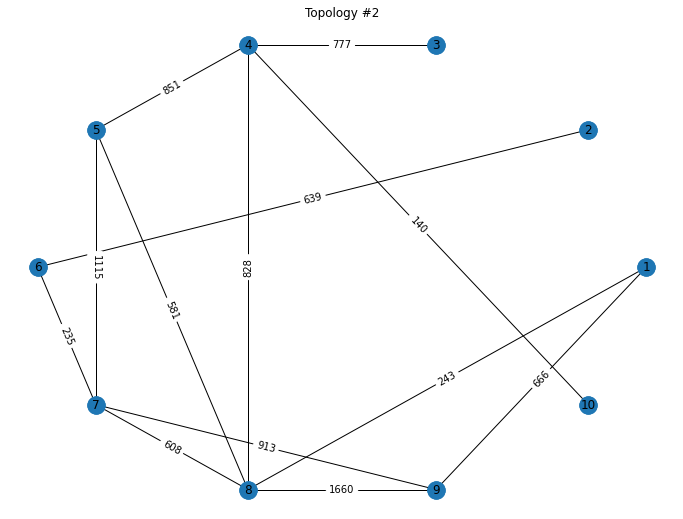

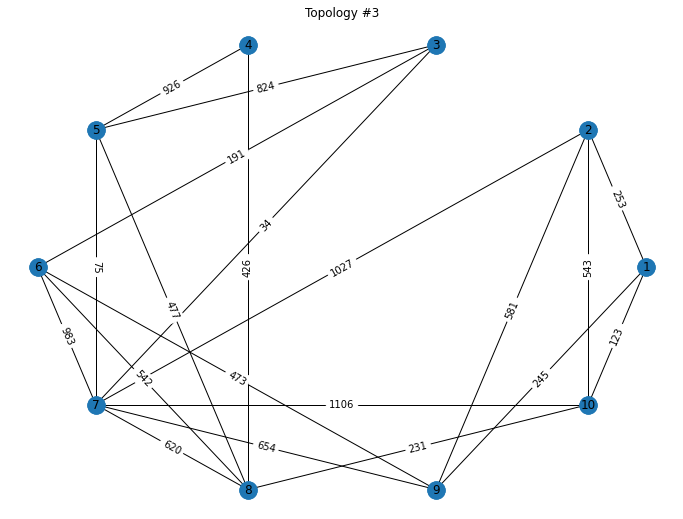

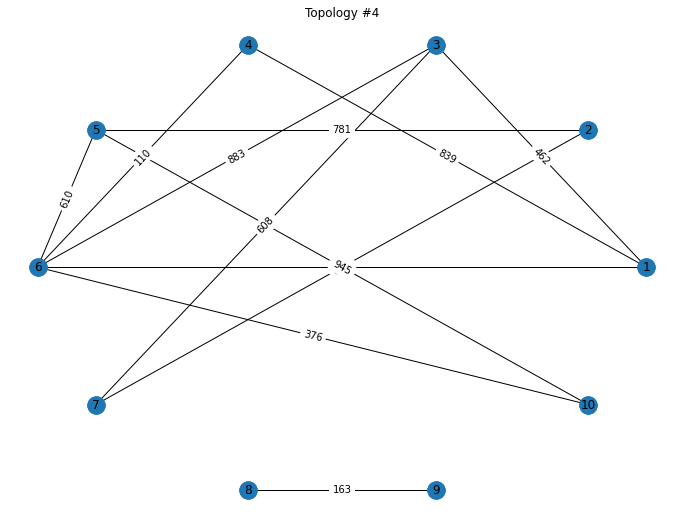

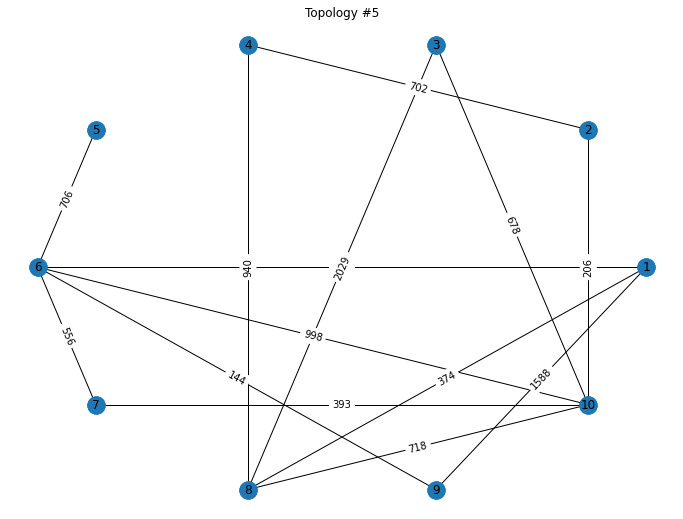

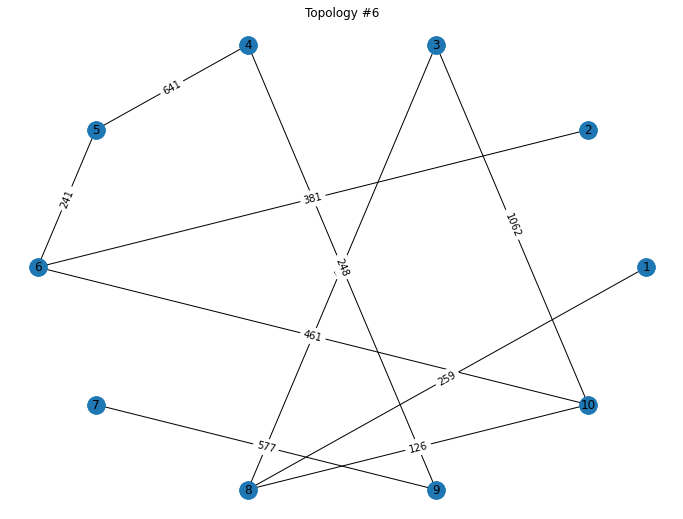

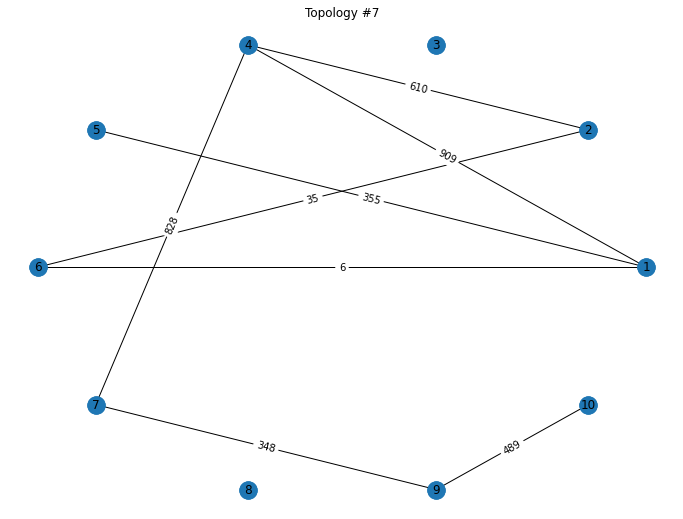

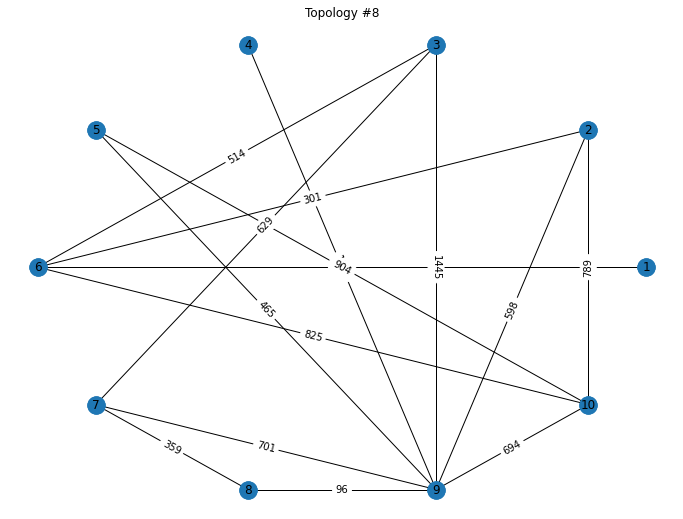

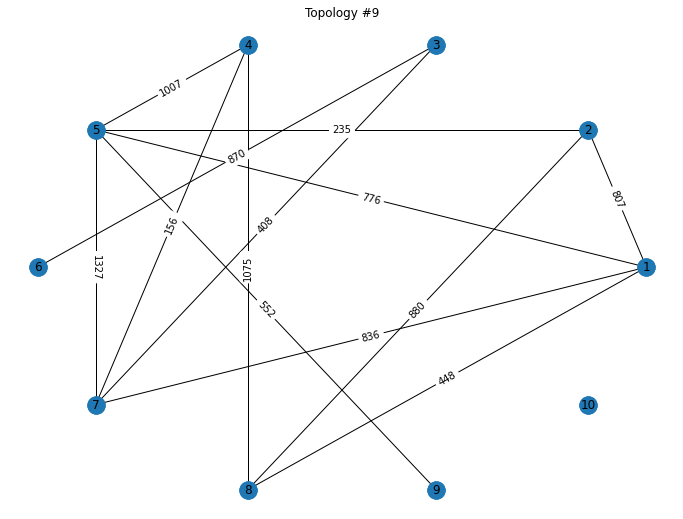

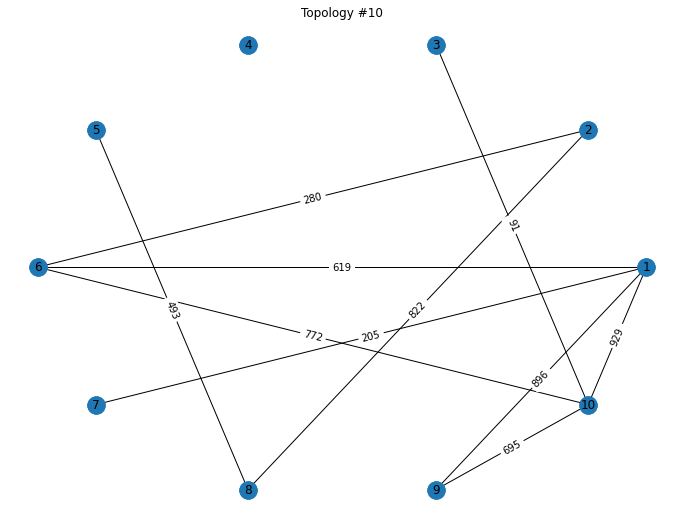

In [10]:
for i in range(10):
  draw_graph(topology_10[i], title = 'Topology #{}'.format(i + 1))

# Topology Mapping

### Function to spectral cluster a topology

In [0]:
from sklearn import preprocessing
from sklearn.cluster import KMeans

def spectral_cluster(adj, k = [2]):
  D = np.diag(adj.sum(axis = 1))
  L = D - adj
  D_inv = np.linalg.pinv(D)
  La = D_inv.dot(L)
  Eigenvalues, Eigenvectors = np.linalg.eig(La)
  idx = Eigenvalues.argsort()
  Eigenvalues = Eigenvalues[idx]
  Eigenvectors = Eigenvectors[:,idx]
  ret = []
  true = truth_10[1] ##############
  for k_curr in k:
    W = Eigenvectors[:, :k_curr]
    kmeans = KMeans(n_clusters = k_curr, random_state = 0).fit(W)
    pred = kmeans.labels_
    #print(f_measure(true, pred, k_curr))
    #print(conditional_entropy(true, pred, k_curr))
    ret.append(pred)
  return np.reshape(np.array(ret), (len(k), len(adj)))

# Internal Evaluation Methods

## F-Measure Function

In [0]:
def f_measure(true_data , pred_data , k):
  k_true = np.amax(true_data)+1
  clusters = np.zeros((k,k_true))
  for i in range(pred_data.size):
    clusters[pred_data[i]][true_data[i]] += 1
  fmeasure_sum = 0.0
  for cluster in clusters:  
    max_index = np.argmax(cluster) 
    total = np.sum(cluster) 
    purity = cluster[max_index]/total
    recall = cluster[max_index]/np.sum(clusters[:,max_index], axis = 0)
    fmeasure_sum += (2 * purity * recall) / (purity + recall)
  return fmeasure_sum/k

## Conditional Entropy Function

In [0]:
import math

def conditional_entropy(true_data , pred_data , k):
  k_true = np.amax(true_data) + 1
  clusters = np.zeros((k, k_true))
  for i in range(pred_data.size):
    clusters[pred_data[i]][true_data[i]] += 1
  entropy_sum = 0.0
  for cluster in clusters:   
    total = np.sum(cluster)
    curr = np.sum(np.array([((x/total)*math.log(x/total, 2)) for x in cluster if x != 0]))
    entropy_sum += (-curr) * total/len(true_data)
  return entropy_sum

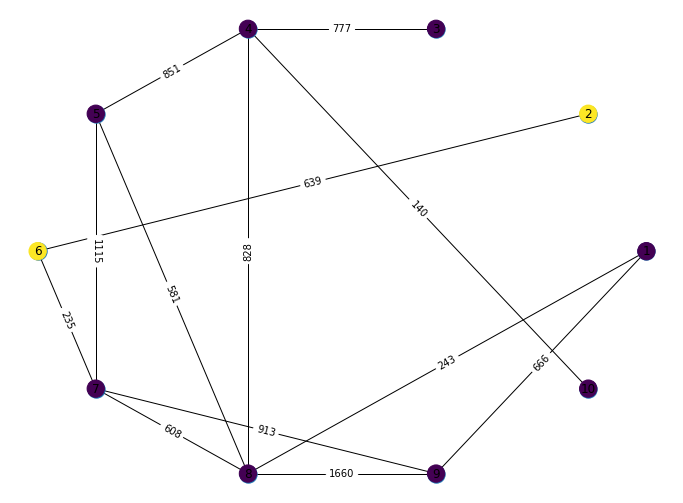

In [14]:
#############################################
k = [2]
labels = spectral_cluster(topology_10[1], k = k)
for i in range(len(k)):
  draw_graph(topology_10[1], col = labels[i])

# Internal Evaluation Methods

## Normalized Cut Functions

In [0]:
def pre_ncut(topology):
  dist_matrix = np.zeros((topology.shape[0],topology.shape[1]))
  for i in range(topology.shape[0]):
    for j in range(i, topology.shape[1]):
      dist_matrix[i][j] = math.exp(-0.01*max(topology[i][j],1))
      dist_matrix[j][i] = math.exp(-0.01*max(topology[i][j],1))
  degree_matrix = np.diag(dist_matrix.sum(axis = 1))
  return dist_matrix, degree_matrix

In [0]:
def W(labels, ind, dist, deg):
  mask = np.multiply(np.array(labels == ind), 1)
  internal = mask.dot(dist.dot(mask.T))
  external = mask.dot(deg.dot(mask.T)) - internal
  return internal, external

def n_cut(topology, labels, k):
  dist_matrix, deg_matrix = pre_ncut(topology)
  tot = 0
  for i in range(k):
    internal, external = W(labels, i, dist_matrix, deg_matrix)
    tot += external /(internal + external)
  return tot

# Different Ks for different Topologies

In [0]:
ks_10 = np.array([2,4,6,8,10])
ks_50 = ks_100 = np.array([2,10,12,15,17,20,25])

# Evaluating Different Topologies (WRT Ground Truth)

## Size 10 Topology Evaluation

### Precaculating labels

In [0]:
#labels_10[topology_number][k] = [labels]
labels_10 = np.array([spectral_cluster(topology_10[i], ks_10) for i in range(10)])

### Calculating Fmeasure & Conditional Entropy

In [0]:
#fmeasure[topology_number][k] = number
fmeasure_10 = np.zeros((10, len(ks_10)))
entropy_10 = np.zeros((10, len(ks_10)))
for i in range(10):
  fmeasure_10[i] = np.array([f_measure(truth_10[i], labels_10[i][x], ks_10[x]) for x in range(len(ks_10))])
  entropy_10[i] = np.array([conditional_entropy(truth_10[i], labels_10[i][x], ks_10[x]) for x in range(len(ks_10))])

### Finding best clustering

In [0]:
best_fmeasure_ind_10 = np.array([np.argmax(fmeasure_10[x]) for x in range(len(fmeasure_10))])
best_entropy_ind_10 = np.array([np.argmin(entropy_10[x]) for x in range(len(entropy_10))])

## Comparing clusterings with ground truth labels

### Function to draw a cluster with different labels 

In [0]:
def compare_clusters(topology, cols = None, title = None):
  #cols is an array of different colours
  shift = 0
  plt.figure(figsize = (16, 6))
  ax = plt.gca()
  ax.axis('off')
  no_f, no_e, no_t = np.amax(cols[0]) + 1, np.amax(cols[1]) + 1, np.amax(cols[2]) + 1
  print('Best F-measure Clustering (K = {})  -  Best Entropy Clustering (K = {})  -\
  Ground Truth Clustering (K = {})'.format(no_f, no_e, no_t).center(100))
  for col in cols:
    G = nx.from_numpy_matrix(np.matrix(topology), create_using=nx.Graph)
    layout = nx.circular_layout(G)
    for _,v in layout.items():
     v[0] = v[0] + shift
    labels = nx.get_edge_attributes(G, "weight")
    nodes = {x : x + 1 for x in range(topology.shape[0])}
    nx.draw_networkx(G, pos = layout, with_labels = False)
    nx.draw_networkx_edge_labels(G, pos = layout, edge_labels= labels);
    nx.draw_networkx_labels(G, layout, nodes, font_size= 12)
    nx.draw_networkx_nodes(G, pos = layout, node_color = col)
    shift += 3
  plt.title(title)
  plt.show()
  plt.draw()
  plt.close()

                                          FOR TOPOLOGY = 0                                          

Best F-measure Clustering (K = 10)  -  Best Entropy Clustering (K = 10)  -  Ground Truth Clustering (K = 5)


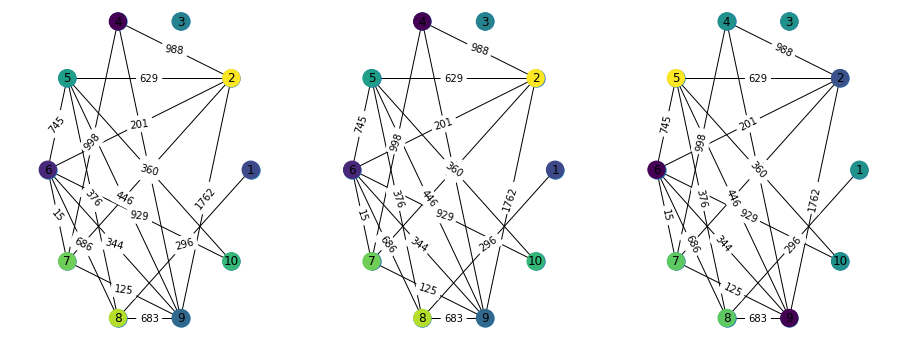

                                          FOR TOPOLOGY = 1                                          

Best F-measure Clustering (K = 4)  -  Best Entropy Clustering (K = 10)  -  Ground Truth Clustering (K = 2)


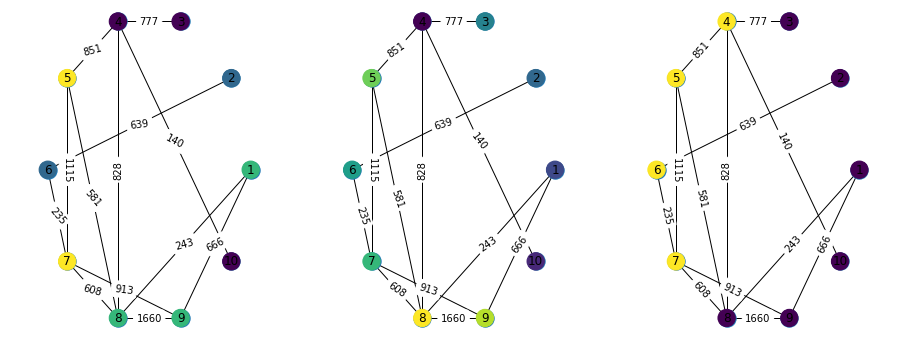

                                          FOR TOPOLOGY = 2                                          

Best F-measure Clustering (K = 2)  -  Best Entropy Clustering (K = 10)  -  Ground Truth Clustering (K = 2)


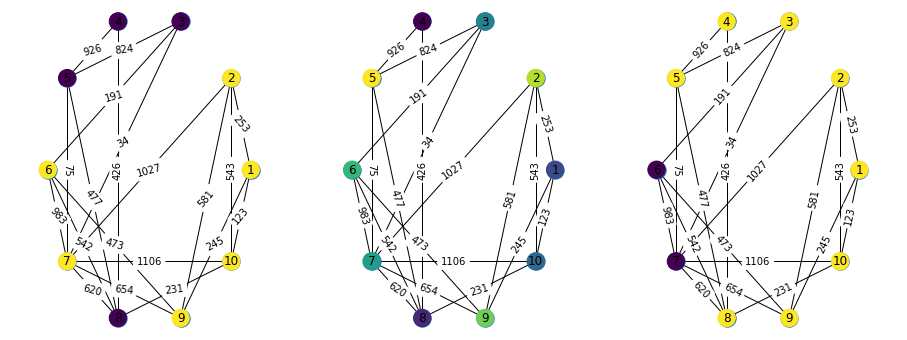

                                          FOR TOPOLOGY = 3                                          

Best F-measure Clustering (K = 2)  -  Best Entropy Clustering (K = 10)  -  Ground Truth Clustering (K = 2)


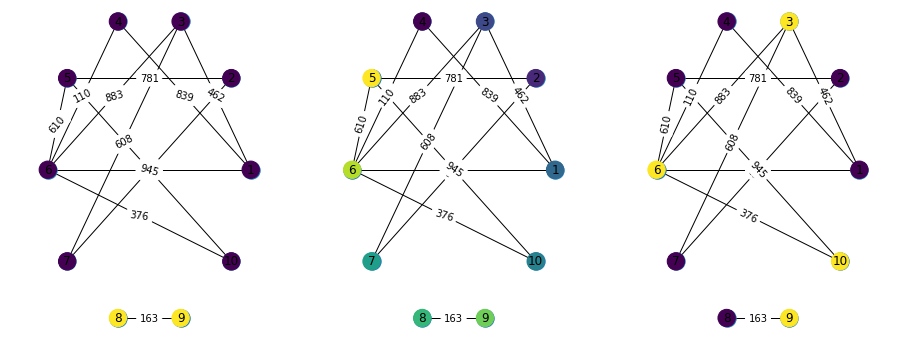

                                          FOR TOPOLOGY = 4                                          

Best F-measure Clustering (K = 10)  -  Best Entropy Clustering (K = 10)  -  Ground Truth Clustering (K = 4)


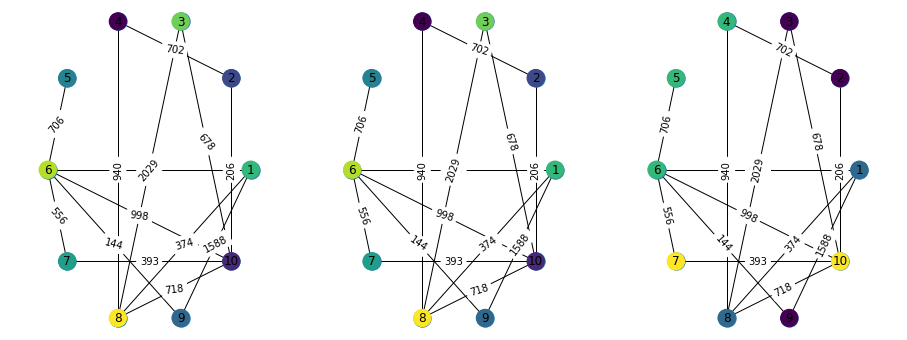

                                          FOR TOPOLOGY = 5                                          

Best F-measure Clustering (K = 4)  -  Best Entropy Clustering (K = 8)  -  Ground Truth Clustering (K = 2)


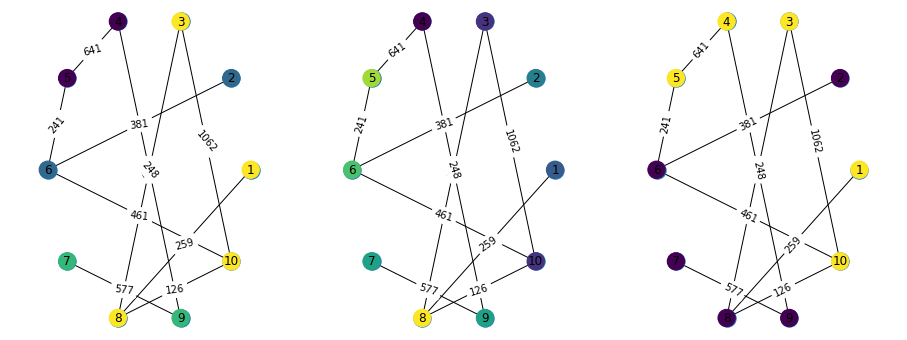

                                          FOR TOPOLOGY = 6                                          

Best F-measure Clustering (K = 2)  -  Best Entropy Clustering (K = 2)  -  Ground Truth Clustering (K = 1)


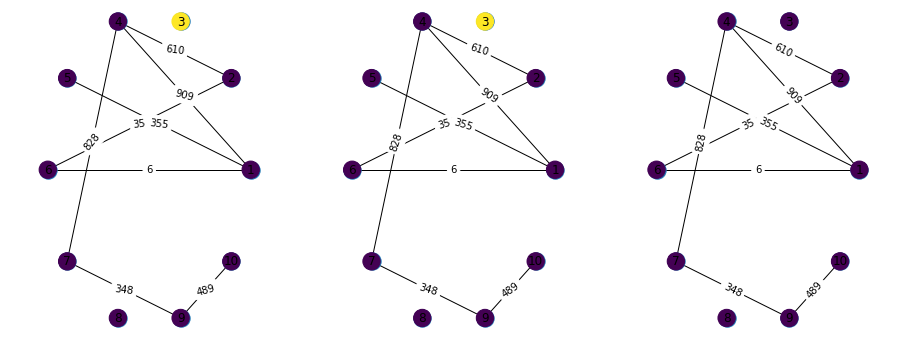

                                          FOR TOPOLOGY = 7                                          

Best F-measure Clustering (K = 2)  -  Best Entropy Clustering (K = 8)  -  Ground Truth Clustering (K = 2)


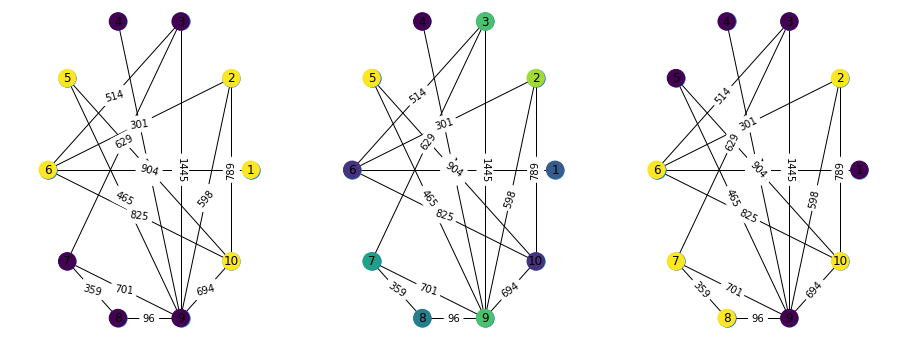

                                          FOR TOPOLOGY = 8                                          

Best F-measure Clustering (K = 4)  -  Best Entropy Clustering (K = 10)  -  Ground Truth Clustering (K = 4)


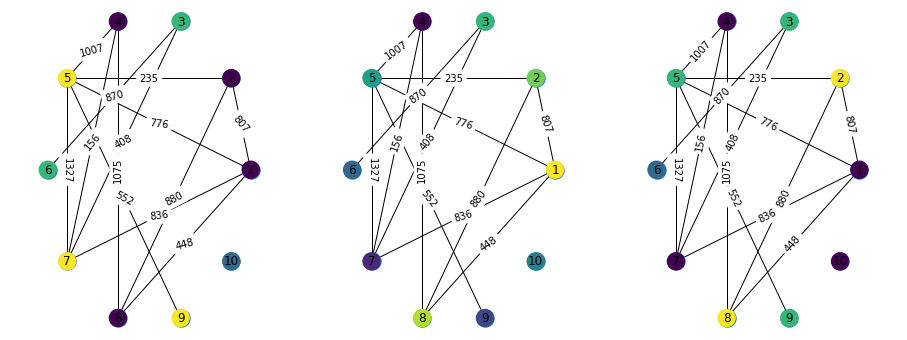

                                          FOR TOPOLOGY = 9                                          

Best F-measure Clustering (K = 2)  -  Best Entropy Clustering (K = 2)  -  Ground Truth Clustering (K = 1)


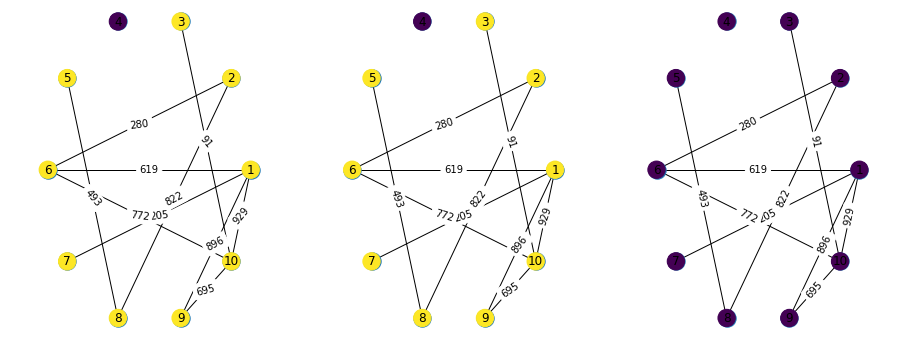

In [22]:
for i in range(10):
  best_f, best_e = best_fmeasure_ind_10[i], best_entropy_ind_10[i]
  print('FOR TOPOLOGY = {}'.format(i).center(100), end = '\n\n')
  compare_clusters(topology_10[i], [labels_10[i][best_f], labels_10[i][best_e], truth_10[i]])
  print('==========================================================='.center(100))

## Size 50 Topology Evaluation

### Precaculating labels

In [0]:
#labels_50[topology_number][k] = [labels]
labels_50 = np.array([spectral_cluster(topology_50[i], ks_50) for i in range(10)])

### Calculating Fmeasure & Conditional Entropy

In [0]:
#fmeasure[topology_number][k] = number
fmeasure_50 = np.zeros((10, len(ks_50)))
entropy_50 = np.zeros((10, len(ks_50)))
for i in range(10):
  fmeasure_50[i] = np.array([f_measure(truth_50[i], labels_50[i][x], ks_50[x]) for x in range(len(ks_50))])
  entropy_50[i] = np.array([conditional_entropy(truth_50[i], labels_50[i][x], ks_50[x]) for x in range(len(ks_50))])

### Finding best clustering

In [0]:
best_fmeasure_ind_50 = np.array([np.argmax(fmeasure_50[x]) for x in range(len(fmeasure_50))])
best_entropy_ind_50 = np.array([np.argmin(entropy_50[x]) for x in range(len(entropy_50))])

## Drawing best clusterings for each topology

                                          FOR TOPOLOGY = 0                                          

Best F-measure Clustering (K = 2)  -  Best Entropy Clustering (K = 25)  -  Ground Truth Clustering (K = 25)


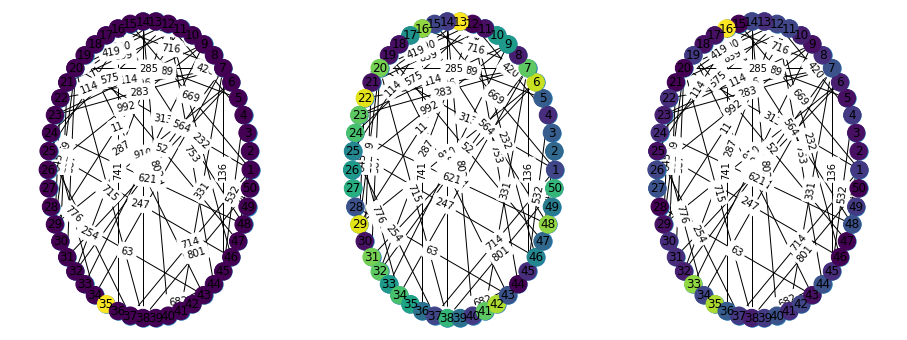

                                          FOR TOPOLOGY = 1                                          

Best F-measure Clustering (K = 25)  -  Best Entropy Clustering (K = 25)  -  Ground Truth Clustering (K = 22)


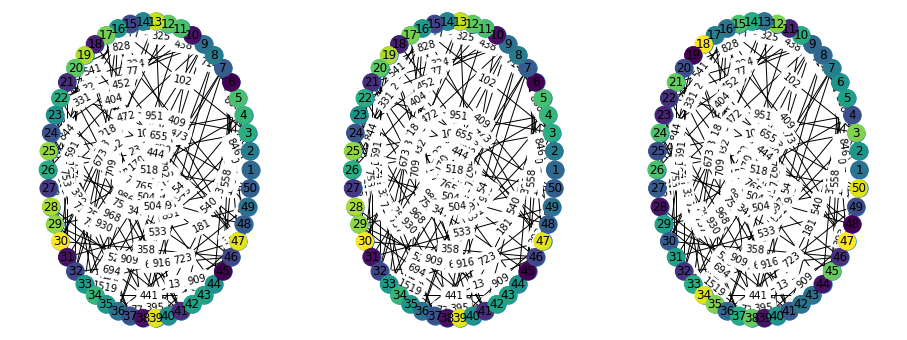

                                          FOR TOPOLOGY = 2                                          

Best F-measure Clustering (K = 25)  -  Best Entropy Clustering (K = 25)  -  Ground Truth Clustering (K = 25)


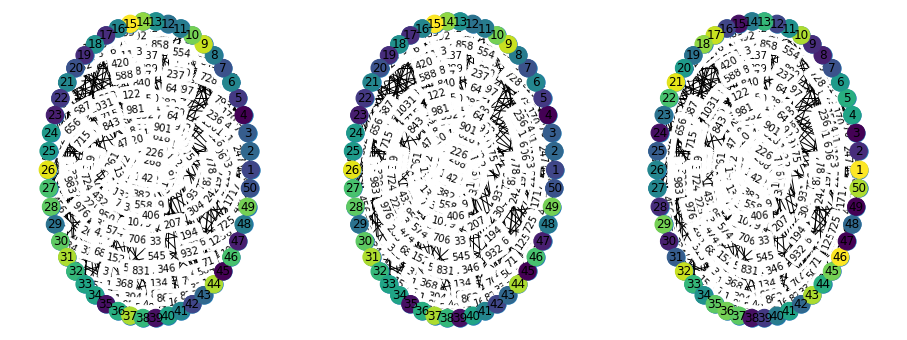

                                          FOR TOPOLOGY = 3                                          

Best F-measure Clustering (K = 25)  -  Best Entropy Clustering (K = 25)  -  Ground Truth Clustering (K = 25)


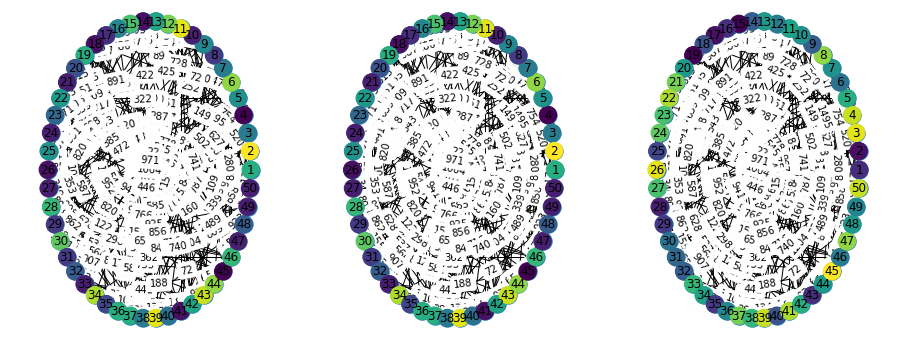

                                          FOR TOPOLOGY = 4                                          

Best F-measure Clustering (K = 10)  -  Best Entropy Clustering (K = 25)  -  Ground Truth Clustering (K = 22)


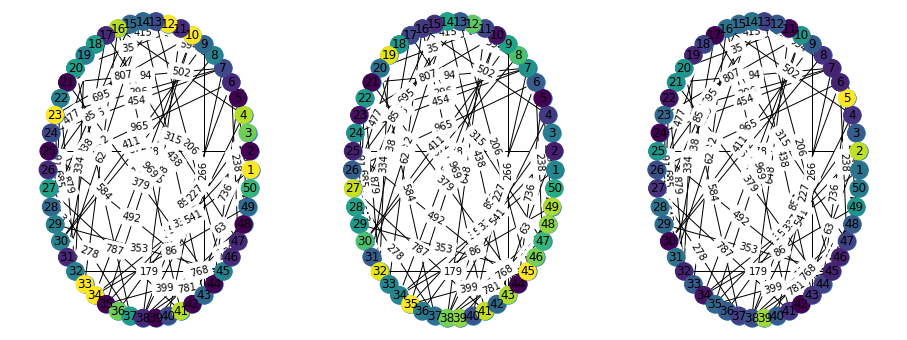

                                          FOR TOPOLOGY = 5                                          

Best F-measure Clustering (K = 17)  -  Best Entropy Clustering (K = 25)  -  Ground Truth Clustering (K = 22)


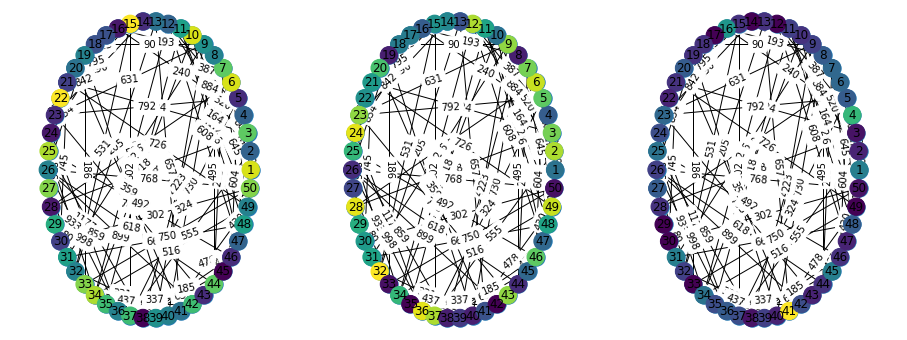

                                          FOR TOPOLOGY = 6                                          

Best F-measure Clustering (K = 2)  -  Best Entropy Clustering (K = 25)  -  Ground Truth Clustering (K = 21)


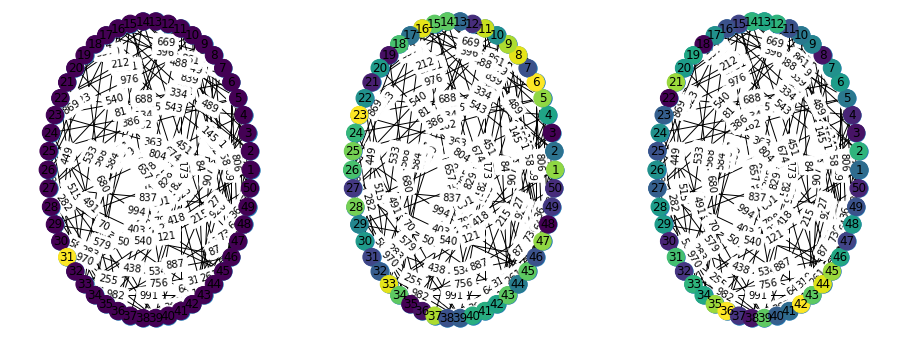

                                          FOR TOPOLOGY = 7                                          

Best F-measure Clustering (K = 25)  -  Best Entropy Clustering (K = 25)  -  Ground Truth Clustering (K = 23)


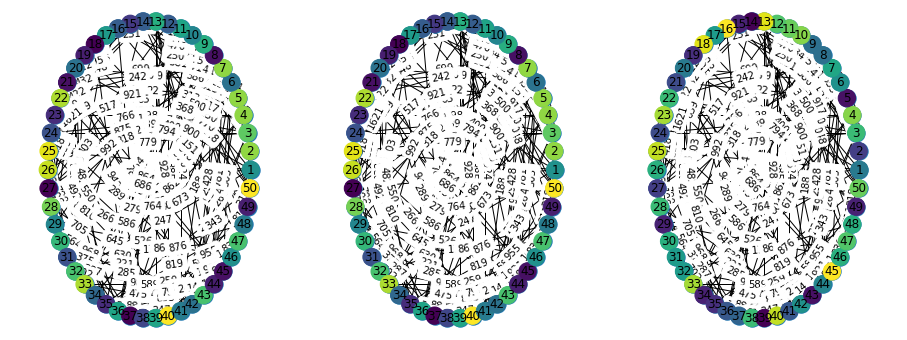

                                          FOR TOPOLOGY = 8                                          

Best F-measure Clustering (K = 10)  -  Best Entropy Clustering (K = 25)  -  Ground Truth Clustering (K = 22)


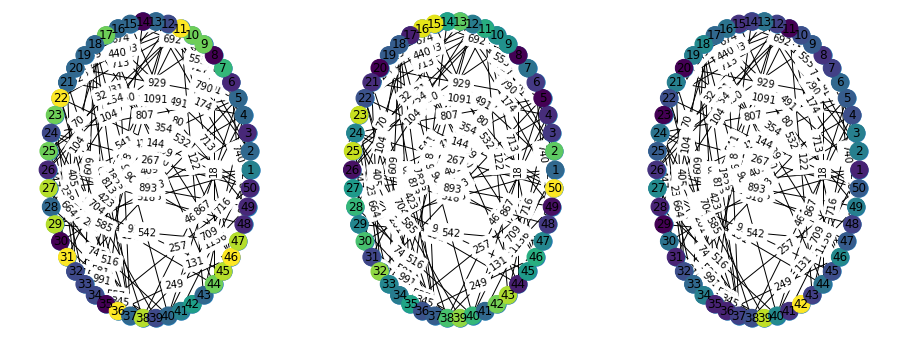

                                          FOR TOPOLOGY = 9                                          

Best F-measure Clustering (K = 10)  -  Best Entropy Clustering (K = 25)  -  Ground Truth Clustering (K = 16)


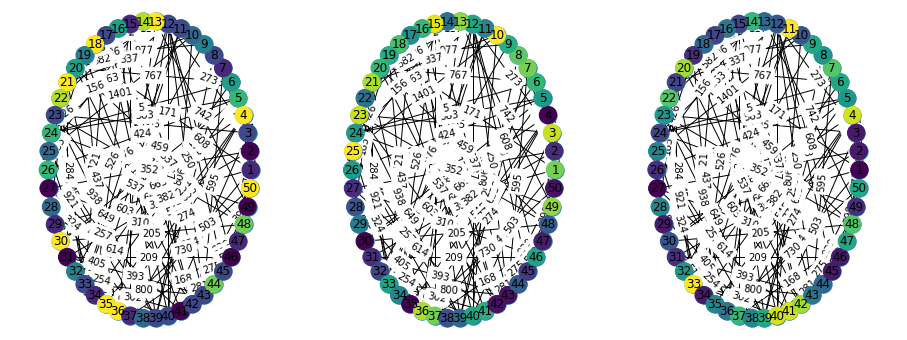

In [26]:
for i in range(10):
  print('FOR TOPOLOGY = {}'.format(i).center(100), end = '\n\n')
  best_f, best_e = best_fmeasure_ind_50[i], best_entropy_ind_50[i]
  compare_clusters(topology_50[i], [labels_50[i][best_f], labels_50[i][best_e], truth_50[i]])
  print('==========================================================='.center(100))

# Normalized Cut Evaluation for different Topologies & Clusterings

### Function to print Emulated & Simulated Traffic

In [0]:
def print_nmeasure(topology, labels):
  total_externally = 0.0
  total_internally = []
  for j in range(int(np.amax(labels))+1):
    inernally,externally = W(labels, j , topology, np.diag(topology.sum(axis = 1)))
    total_internally.append(inernally)
    total_externally += externally
  print("Total Emulated Traffic = ",total_externally/2)
  print('Total Simulated Traffic = ', total_internally)

## Finding Emulated & Simulated Traffic for each Clustering (Size 10)

In [28]:
for i in range(10):
  best_f, best_e = best_fmeasure_ind_10[i], best_entropy_ind_10[i]
  print('FOR TOPOLOGY = {}'.format(i).center(100), end = '\n\n')
  print('Best F-measure Clustering : ',)
  print_nmeasure(topology_10[i], labels_10[i][best_f])
  print('\nBest Entropy Clustering : ')
  print_nmeasure(topology_10[i], labels_10[i][best_e])
  print('\n','==========================================================='.center(100))

                                          FOR TOPOLOGY = 0                                          

Best F-measure Clustering : 
Total Emulated Traffic =  10502.0
Total Simulated Traffic =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Best Entropy Clustering : 
Total Emulated Traffic =  10502.0
Total Simulated Traffic =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

                                          FOR TOPOLOGY = 1                                          

Best F-measure Clustering : 
Total Emulated Traffic =  4016.0
Total Simulated Traffic =  [1834, 1278, 5138, 2230]

Best Entropy Clustering : 
Total Emulated Traffic =  9256.0
Total Simulated Traffic =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

                                          FOR TOPOLOGY = 2                                          

Best F-measure Clustering : 
Total Emulated Traffic =  1693.0
Total Simulated Traffic =  [5306, 11976]

Best Entropy Clustering : 
Total Emulated Traffic =  10334.0
Total Simulated Traffic =  [0, 0, 0, 0, 0, 0, 0, 0, 0

## Finding Emulated & Simulated Traffic for each Clustering (Size 50)

In [29]:
for i in range(10):
  best_f, best_e = best_fmeasure_ind_50[i], best_entropy_ind_50[i]
  print('FOR TOPOLOGY = {}'.format(i).center(150), end = '\n\n')
  print('Best F-measure Clustering : ',)
  print_nmeasure(topology_50[i], labels_50[i][best_f])
  print('\nBest Entropy Clustering : ')
  print_nmeasure(topology_50[i], labels_50[i][best_e])
  print('\n','==========================================================='.center(150))

                                                                   FOR TOPOLOGY = 0                                                                   

Best F-measure Clustering : 
Total Emulated Traffic =  0.0
Total Simulated Traffic =  [47592, 0]

Best Entropy Clustering : 
Total Emulated Traffic =  10475.0
Total Simulated Traffic =  [1506, 2780, 0, 1064, 1604, 2766, 126, 142, 492, 1654, 0, 494, 0, 4572, 0, 0, 1602, 1552, 2696, 1174, 1128, 0, 0, 1290, 0]

                                                                   FOR TOPOLOGY = 1                                                                   

Best F-measure Clustering : 
Total Emulated Traffic =  34623.0
Total Simulated Traffic =  [1116, 4630, 0, 1972, 0, 2612, 1514, 3432, 0, 2634, 1736, 0, 3370, 2764, 1520, 3266, 1994, 1428, 1656, 0, 964, 1688, 0, 1818, 0]

Best Entropy Clustering : 
Total Emulated Traffic =  34623.0
Total Simulated Traffic =  [1116, 4630, 0, 1972, 0, 2612, 1514, 3432, 0, 2634, 1736, 0, 3370, 2764, 1520,

## Finding Emulated & Simulated Traffic for each Clustering (Size 100)

## Finding Best Clustering of 100 Nodes using N-cut Evaluation

In [0]:
ncut_100 = np.zeros((10, len(ks_100)))
labels_100 = np.zeros((10, len(ks_100),100))
for i in range(10):
  labels_100[i] = spectral_cluster(topology_100[i], ks_100)
  ncut_100[i] = np.array([n_cut(topology_100[i], labels_100[i][x], ks_100[x]) for x in range(len(ks_100))])

best_ncut_ind_100 = np.array([np.argmax(ncut_100[x]) for x in range(len(ncut_100))])

## Finding Emulated & Simulated Traffic for each Clustering (Size 100)

In [31]:
for i in range(10):
  best_ind = best_ncut_ind_100[i]
  print('FOR TOPOLOGY = {}'.format(i).center(100), end = '\n\n')
  print('Best N-cut Clustering : ')
  print_nmeasure(topology_100[i], labels_100[i][best_ind])
  print('\n','==========================================================='.center(100))

                                          FOR TOPOLOGY = 0                                          

Best N-cut Clustering : 
Total Emulated Traffic =  322292.0
Total Simulated Traffic =  [10290, 13876, 6174, 1884, 4032, 7248, 17608, 7594, 11732, 3146, 12306, 18292, 8352, 3882, 4254, 7776, 7802, 14960, 1750, 5782, 5690, 4548, 2222, 2306, 6810]

                                          FOR TOPOLOGY = 1                                          

Best N-cut Clustering : 
Total Emulated Traffic =  106831.0
Total Simulated Traffic =  [7878, 3150, 7900, 1308, 5362, 7134, 10512, 3288, 10338, 5724, 3578, 5030, 8116, 5164, 14532, 4856, 1710, 2846, 1618, 6138, 2442, 7584, 6270, 3374, 1376]

                                          FOR TOPOLOGY = 2                                          

Best N-cut Clustering : 
Total Emulated Traffic =  356443.0
Total Simulated Traffic =  [7582, 7992, 11570, 4668, 7938, 6856, 11414, 12640, 13798, 0, 7452, 3066, 3772, 3034, 6714, 8502, 6744, 12018, 15464, 1